Based on https://bambinos.github.io/bambi/main/notebooks/splines_cherry_blossoms.html

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

az.style.use("arviz-darkgrid")
SEED = 7355608

# Load Cherry Blossom data

In [2]:
data = bmb.load_data("cherry_blossoms")
data

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1210,2011,99.0,NaN,NaN,NaN
1211,2012,101.0,NaN,NaN,NaN
1212,2013,93.0,NaN,NaN,NaN
1213,2014,94.0,NaN,NaN,NaN


In [3]:
data = data.dropna(subset=["doy"]).reset_index(drop=True)
data.shape

(827, 5)

# Explore the data

In [5]:
# We create a function because this plot is going to be used again later
def plot_scatter(data, figsize=(10, 6)):
    _, ax = plt.subplots(figsize=figsize)
    ax.scatter(data["year"], data["doy"], alpha=0.4, s=30)
    ax.set_title("Day of the first bloom per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Days of the first bloom")
    return ax

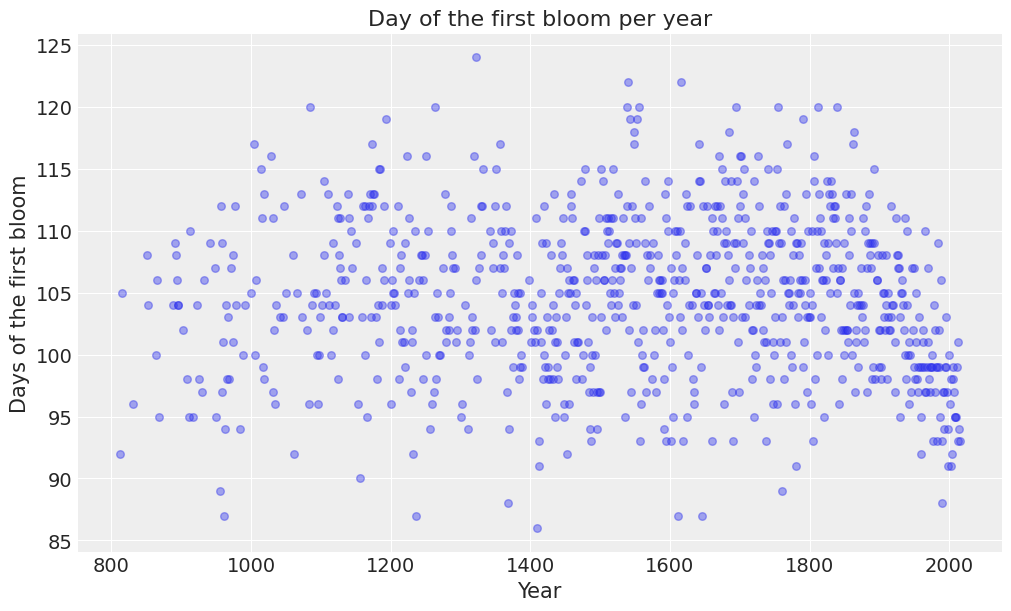

In [6]:
plot_scatter(data);

In [7]:
num_knots = 15
knots = np.quantile(data["year"], np.linspace(0, 1, num_knots))

In [8]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

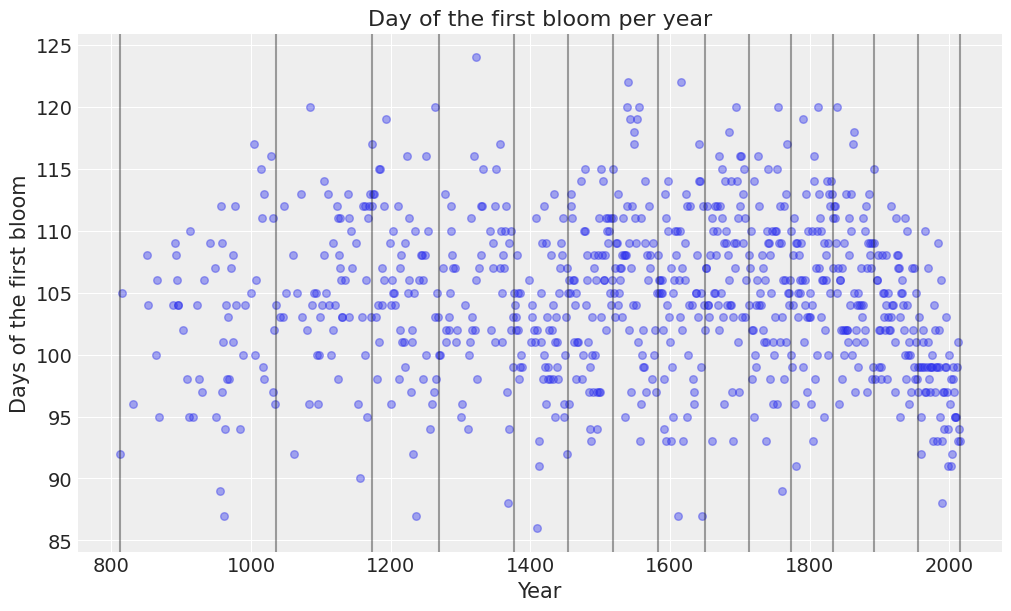

In [9]:
ax = plot_scatter(data)
plot_knots(knots, ax);

# Model

In [10]:
# We only pass the internal knots to the `bs()` function.
iknots = knots[1:-1]

# Define dictionary of priors
priors = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10),
    "common": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1)
}

# Define model
# The intercept=True means the basis also spans the intercept, as originally done in the book example.
model = bmb.Model("doy ~ bs(year, knots=iknots, intercept=True)", data, priors=priors)
model

Formula: doy ~ bs(year, knots=iknots, intercept=True)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 100, sigma: 10)
    bs(year, knots = iknots, intercept = True) ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [11]:
def plot_spline_basis(basis, year, figsize=(10, 6)):
    df = (
        pd.DataFrame(basis)
        .assign(year=year)
        .melt("year", var_name="basis_idx", value_name="value")
    )

    _, ax = plt.subplots(figsize=figsize)

    for idx in df.basis_idx.unique():
        d = df[df.basis_idx == idx]
        ax.plot(d["year"], d["value"])

    return ax

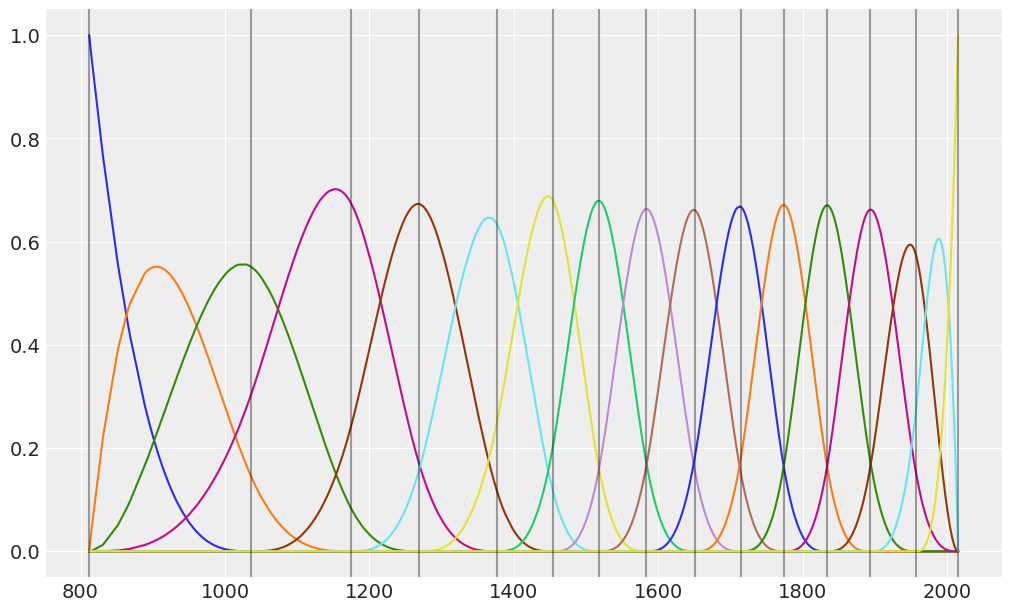

In [12]:
B = model._design.common["bs(year, knots = iknots, intercept = True)"]
ax = plot_spline_basis(B, data["year"].values)
plot_knots(knots, ax);

# Fit model

In [13]:
# The seed is to make results reproducible
idata = model.fit(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(year, knots = iknots, intercept = True), doy_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,103.562,2.503,98.664,107.943,0.095,0.067,697.0,1097.0,1.0
"bs(year, knots = iknots, intercept = True)[0]",-3.136,3.913,-10.408,4.107,0.098,0.069,1608.0,2221.0,1.0
"bs(year, knots = iknots, intercept = True)[1]",-1.074,3.989,-8.399,6.331,0.107,0.076,1377.0,2388.0,1.0
"bs(year, knots = iknots, intercept = True)[2]",-1.262,3.674,-7.919,5.612,0.101,0.071,1335.0,2333.0,1.0
"bs(year, knots = iknots, intercept = True)[3]",4.655,3.019,-1.016,10.342,0.099,0.070,932.0,1748.0,1.0
"bs(year, knots = iknots, intercept = True)[4]",-1.056,2.963,-6.378,4.497,0.098,0.069,923.0,1589.0,1.0
"bs(year, knots = iknots, intercept = True)[5]",4.137,3.065,-1.645,9.828,0.098,0.069,987.0,1929.0,1.0
"bs(year, knots = iknots, intercept = True)[6]",-5.538,2.889,-10.843,-0.099,0.096,0.068,909.0,1628.0,1.0
"bs(year, knots = iknots, intercept = True)[7]",7.604,2.917,2.197,12.964,0.096,0.068,922.0,1788.0,1.0
"bs(year, knots = iknots, intercept = True)[8]",-1.188,2.991,-6.678,4.490,0.098,0.070,921.0,1552.0,1.0


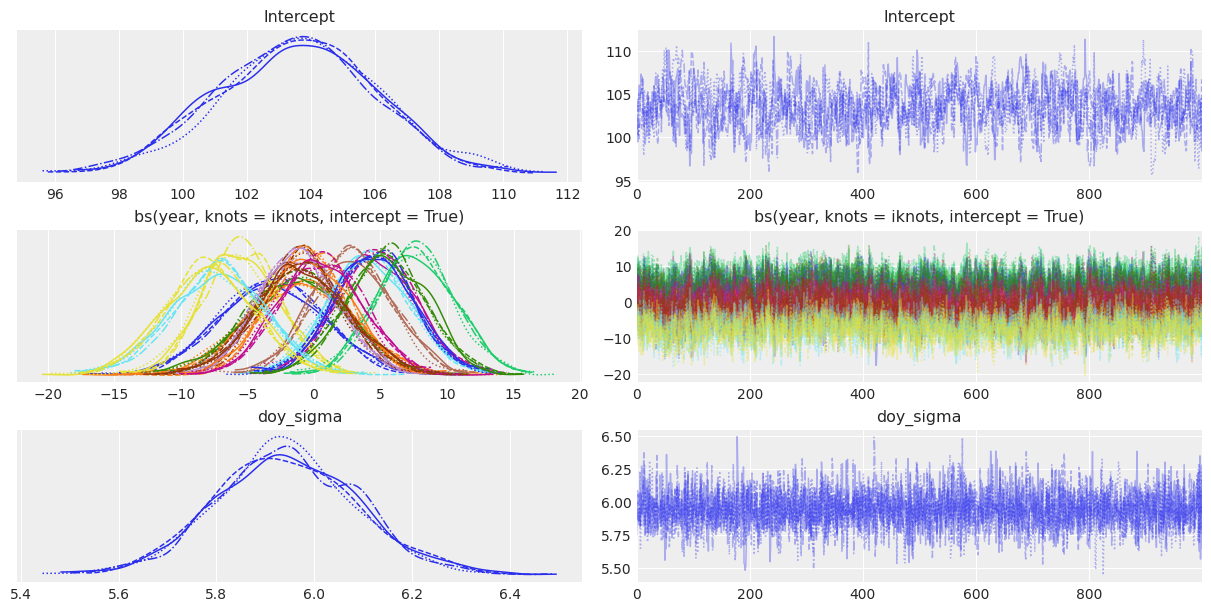

In [15]:
az.plot_trace(idata);

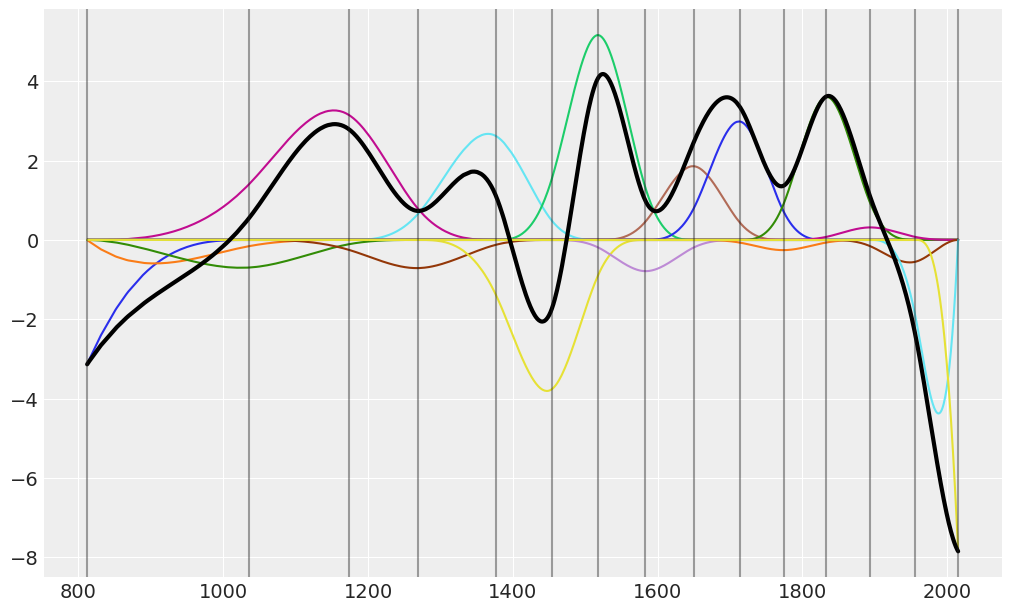

In [16]:
posterior_stacked = az.extract_dataset(idata)
wp = posterior_stacked["bs(year, knots = iknots, intercept = True)"].mean("sample").values

ax = plot_spline_basis(B * wp.T, data["year"].values)
ax.plot(data.year.values, np.dot(B, wp.T), color="black", lw=3)
plot_knots(knots, ax);


In [17]:
def plot_predictions(data, idata, model):
    # Create a test dataset with observations spanning the whole range of year
    new_data = pd.DataFrame({"year": np.linspace(data.year.min(), data.year.max(), num=500)})

    # Predict the day of first blossom
    model.predict(idata, data=new_data)

    posterior_stacked =  az.extract_dataset(idata)
    # Extract these predictions
    y_hat = posterior_stacked["doy_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.03, 0.97], axis=1)

    # Plot obserevd data
    ax = plot_scatter(data)

    # Plot predicted line
    ax.plot(new_data["year"], y_hat_mean, color="firebrick")

    # Plot credibility bands
    ax.fill_between(new_data["year"], hdi_data[0], hdi_data[1], alpha=0.4, color="firebrick")

    # Add knots
    plot_knots(knots, ax)

    return ax

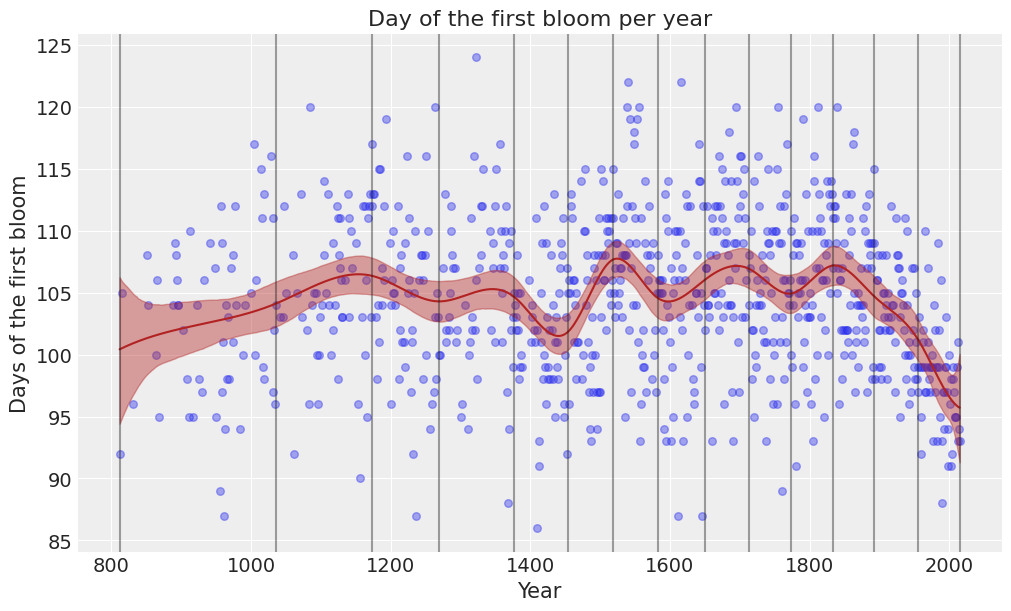

In [18]:
plot_predictions(data, idata, model);

In [19]:
np.round(model._design.common.design_matrix, 3)

array([[1.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.96 , 0.039, ..., 0.   , 0.   , 0.   ],
       [1.   , 0.767, 0.221, ..., 0.   , 0.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   , ..., 0.002, 0.097, 0.902],
       [1.   , 0.   , 0.   , ..., 0.   , 0.05 , 0.95 ],
       [1.   , 0.   , 0.   , ..., 0.   , 0.   , 1.   ]])

In [20]:
model._design.common.design_matrix.shape

(827, 18)

In [21]:
np.linalg.matrix_rank(model._design.common.design_matrix)

17

In [22]:
# Note we use the same priors
model_new = bmb.Model("doy ~ bs(year, knots=iknots)", data, priors=priors)
idata_new = model_new.fit(random_seed=7355608)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(year, knots = iknots), doy_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


In [23]:
az.summary(idata_new)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,102.482,2.062,98.585,106.293,0.063,0.044,1081.0,1373.0,1.0
"bs(year, knots = iknots)[0]",-1.050,4.002,-8.374,6.715,0.100,0.071,1605.0,2296.0,1.0
"bs(year, knots = iknots)[1]",0.387,3.032,-5.190,6.147,0.062,0.044,2391.0,2946.0,1.0
"bs(year, knots = iknots)[2]",5.520,2.722,0.346,10.419,0.071,0.050,1480.0,2133.0,1.0
"bs(year, knots = iknots)[3]",0.126,2.595,-4.783,4.801,0.067,0.048,1495.0,2273.0,1.0
"bs(year, knots = iknots)[4]",5.134,2.711,0.147,10.141,0.066,0.047,1670.0,2320.0,1.0
"bs(year, knots = iknots)[5]",-4.399,2.566,-9.265,0.234,0.067,0.047,1472.0,2376.0,1.0
"bs(year, knots = iknots)[6]",8.673,2.578,3.874,13.491,0.067,0.047,1481.0,2285.0,1.0
"bs(year, knots = iknots)[7]",-0.157,2.673,-5.603,4.479,0.069,0.049,1496.0,2021.0,1.0
"bs(year, knots = iknots)[8]",3.891,2.674,-1.185,8.727,0.067,0.047,1607.0,2323.0,1.0


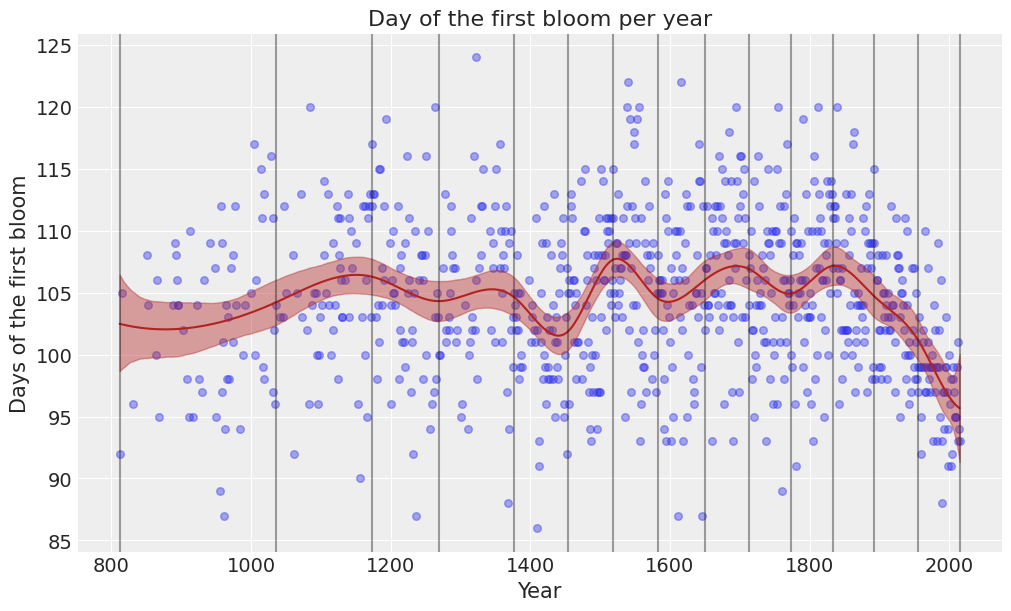

In [24]:
plot_predictions(data, idata_new, model_new);

In [25]:
models_dict = {"Original": idata, "New": idata_new}
df_compare = az.compare(models_dict)
df_compare

/home/pawel/Development/bayesian-regression/venv/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
New,0,-2657.891824,15.989784,0.000000,1.0,21.177794,0.000000,False,log
Original,1,-2658.399482,16.720585,0.507658,0.0,21.192879,0.574283,True,log


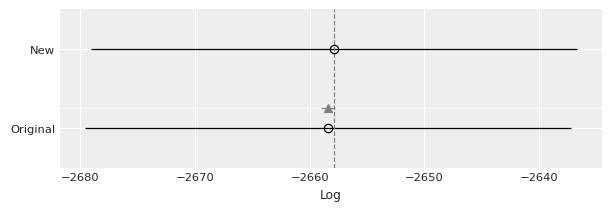

In [26]:
az.plot_compare(df_compare, insample_dev=False);

In [27]:
# Compute pointwise LOO
loo_1 = az.loo(idata, pointwise=True)
loo_2 = az.loo(idata_new, pointwise=True)

/home/pawel/Development/bayesian-regression/venv/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


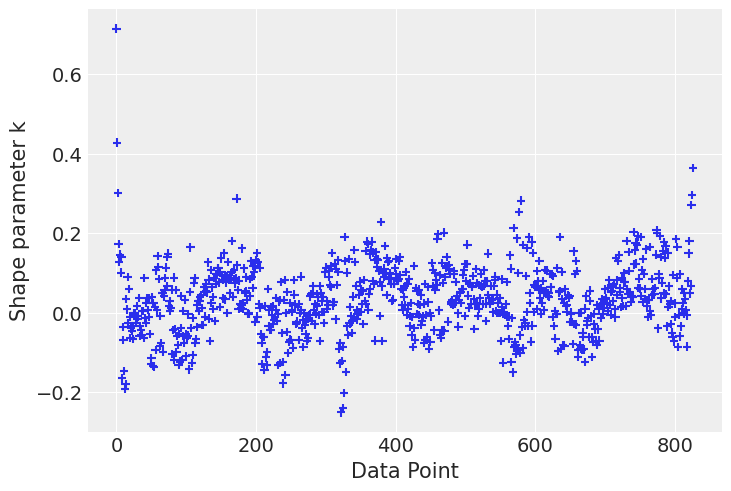

In [28]:
# plot kappa values
az.plot_khat(loo_1.pareto_k);

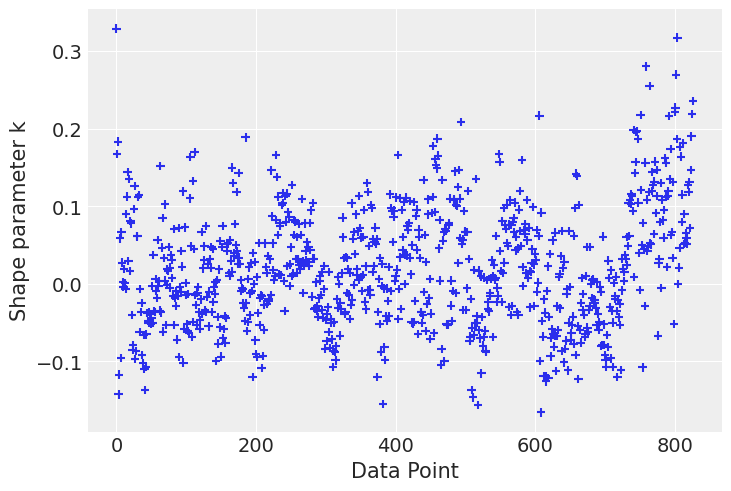

In [29]:
az.plot_khat(loo_2.pareto_k);

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Aug 19 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

pandas    : 1.4.3
matplotlib: 3.5.3
bambi     : 0.9.0
numpy     : 1.21.6
arviz     : 0.12.1

Watermark: 2.3.1

